# Introduction to Bootstrapping regression

## Data Science 410

Perviously, we have investigated the bootstrap resampling method. We used bootstrap resampling to compute a point estiamte and confidence interval for simple univariate statistics.      

The bootstrap method can also be applied to regresson models. Computing the bootstrape distirbution of the regression model parameters provides insight into variability of these parameters. It is useful to know how much random variation there is in regression coeficients simply because a small change in training data values. 

As with most statistics, it is possible to bootstrap the parameters of most any regression model. However, since bootstrap resampling uses a large number of subsamples, it can be computationally intensive. For large-scale problems it is necessary to using other resampling methods like cross-validation.



## An Example

Let's try an example. We will work with a simple regression model simplilar to the one used in the one used in the Introduction to Regression notebook. 

As a fist step, exectute the code in the cell below to generate the synthetic data set. 

In [3]:
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as sm

In [4]:
# Paramters of generated data
n_points = 50
x_start, x_end = 0, 10
y_start, y_end = 0, 10
y_sd = 1

# Generate data columns
nr.seed(5666)
x_data = np.linspace(x_start, x_end, n_points) # The x values
y_error = np.random.normal(loc=0, scale=y_sd, size=n_points) # The Normally distributed noise
y_data = np.linspace(y_start, y_end, n_points) + y_error + 1.0 # The y values including an intercept

# Put data in dataframe
sim_data = pd.DataFrame({'x':x_data, 'y':y_data})

sim_data.head()

,x,y
0,0.000000,1.475868
1,0.204082,0.915564
2,0.408163,2.216802
3,0.612245,1.362557
4,0.816327,3.521151


(0, 11)

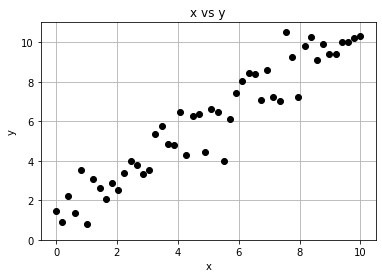

In [5]:
# Matplotlib may give some font errors when loading for the first time, you can ignore these
plt.plot(sim_data['x'], sim_data['y'], 'ko')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('x vs y')
plt.ylim(0,11)

### Resample Points (Parametric Bootstrap)

The first type of bootstrapping we will perform is resampling points.

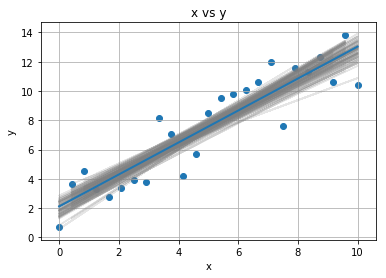

In [64]:
# Resample with replacement each row
boot_slopes = []
boot_interc = []
n_boots = 100
plt.figure()
for _ in range(n_boots):
    # Create a sampling of the rows, same size, with replacement
    sample_df = data_df.sample(n=n_points, replace=True)
    # Fit a linear regression
    ols_model_temp = sm.ols(formula = 'y ~ x', data=sample_df)
    results_temp = ols_model_temp.fit()
    
    # Get the intercept and slope, and record it
    boot_interc.append(results_temp.params[0])
    boot_slopes.append(results_temp.params[1])
    
    # Plot a greyed out line
    y_pred_temp = ols_model_temp.fit().predict(sample_df['x'])
    plt.plot(sample_df['x'], y_pred_temp, color='grey', alpha=0.2)

# Add points
plt.scatter(x, y)
plt.plot(x, y_pred, linewidth=2)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('x vs y')

Notice the shape of the greyed bands.  They are more concentrated at the center than the edge.  This is because more points are positioned around the center than the edges.

Let's look at the distributions of the slope and intercepts.

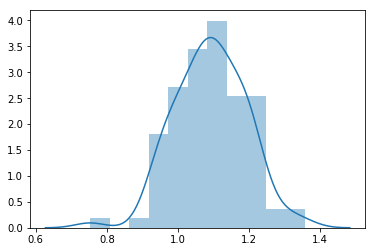

In [65]:
sns.distplot(boot_slopes)

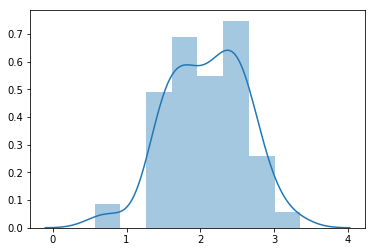

In [66]:
sns.distplot(boot_interc)

From these above plots and sets of data it is easy to determine a confidence interval for our linear regression parameters if need be.

# Your Turn

### Question:

From the above sets of 100 slopes and 100 intercepts, what would be a good 90% confidence interval for our slope and intercept?

In [67]:
# Hint: think of sorting the slopes and intercepts first.

But our data is very nice here.  If by chance we had sparse data, there may be a chance that our random selection of points are entirely in one area and not in another.  To combat this, we can apply a different type of bootstrapping, called 'Non-Parametric Bootstrapping' in which we will apply bootstrapping on the residuals.

### Resample Residuals (Non-Parametric Bootstrapping)

The idea is that we want to observe a point at every x-position that we have a point in the original data.  So we fit the original data and re-shuffle the residuals at every point.  This should be fine because we are assuming that the errors are i.i.d. among our points.

In [68]:
# Create sample data
n_points = 25
x = np.linspace(0, 10, n_points)
y = x + (np.random.rand(len(x)) * 5)
data_df = pd.DataFrame({'x': x, 'y': y})

# Fit linear regression model
ols_model = sm.ols(formula = 'y ~ x', data=data_df)
results = ols_model.fit()

# Get predicted values
y_pred = results.predict(x)

# Get residual values
resids = results.resid

Now that we have the fitted values and residuals from our fit, we will generate N (100) new sets of data by sampling the residuals and adding them to the fitted values.

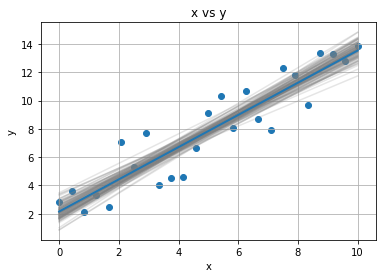

In [85]:
boot2_slopes = []
boot2_interc = []
n_boots = 100
plt.figure()
for _ in range(n_boots):
    # Create a sampling of the residuals with replacement
    boot_resids = np.random.choice(resids, n_points, replace=True)
    y_temp = [y_pred_i + resid_i for y_pred_i, resid_i in zip(y_pred, boot_resids)]
    
    sample_df = pd.DataFrame({'x': list(x), 'y': y_temp})
    # Fit a linear regression
    ols_model_temp = sm.ols(formula = 'y ~ x', data=sample_df)
    results_temp = ols_model_temp.fit()
    
    # Get the intercept and slope, and record it
    boot2_interc.append(results_temp.params[0])
    boot2_slopes.append(results_temp.params[1])
    
    # Plot a greyed out line
    y_pred_temp = ols_model_temp.fit().predict(sample_df['x'])
    plt.plot(sample_df['x'], y_pred_temp, color='grey', alpha=0.2)

# Add points
plt.scatter(x, y)
plt.plot(x, y_pred, linewidth=2)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('x vs y')

Let's look again at the distributions of the parameters:

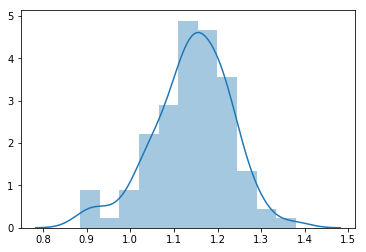

In [86]:
sns.distplot(boot2_slopes)

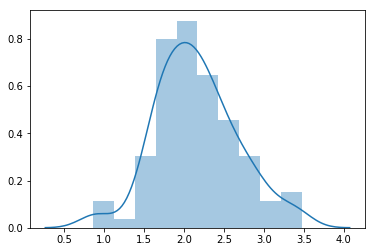

In [87]:
sns.distplot(boot2_interc)